<a href="https://colab.research.google.com/github/hemil19/AISem3/blob/master/hw/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Submission by : Hemil Shah(D011)**

In [1]:
#!pip3 install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [4]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [5]:
!kaggle competitions download -c home-credit-default-risk

 95% 103M/109M [00:00<00:00, 129MB/s] 
100% 109M/109M [00:00<00:00, 124MB/s]
 83% 47.0M/56.8M [00:00<00:00, 94.9MB/s]
100% 56.8M/56.8M [00:00<00:00, 95.4MB/s]
 98% 265M/271M [00:02<00:00, 116MB/s]
100% 271M/271M [00:02<00:00, 101MB/s]
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
 98% 36.0M/36.8M [00:00<00:00, 62.6MB/s]
100% 36.8M/36.8M [00:00<00:00, 65.8MB/s]
100% 76.0M/76.3M [00:01<00:00, 46.1MB/s]
100% 76.3M/76.3M [00:01<00:00, 42.7MB/s]
 94% 34.0M/36.1M [00:00<00:00, 83.9MB/s]
100% 36.1M/36.1M [00:00<00:00, 81.5MB/s]
  0% 0.00/5.81M [00:00<?, ?B/s]
100% 5.81M/5.81M [00:00<00:00, 53.4MB/s]
 93% 90.0M/96.7M [00:02<00:00, 65.0MB/s]
100% 96.7M/96.7M [00:02<00:00, 43.5MB/s]


In [6]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  POS_CASH_balance.csv.zip
replace POS_CASH_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  bureau_balance.csv.zip
replace bureau_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  installments_payments.csv.zip
replace installments_payments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  bureau.csv.zip
replace bureau.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  previous_application.csv.zip
replace previous_application.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  application_train.csv.zip
replace application_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  application_test.csv.zip
replace application_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  credit_card_balance.csv.zip
replace credit_card_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

8 archives were successfully processed.


In [7]:
!ls

application_test.csv	 HomeCredit_columns_description.csv
application_train.csv	 installments_payments.csv
bureau_balance.csv	 kaggle.json
bureau.csv		 POS_CASH_balance.csv
catboost_info		 previous_application.csv
credit_card_balance.csv  sample_submission.csv


In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
train=pd.read_csv('application_train.csv')
#bureau=pd.read_csv('bureau.csv')
#bureau_balance=pd.read_csv('bureau_balance.csv')
#credit_card_balance=pd.read_csv('credit_card_balance.csv')
#installments_payments=pd.read_csv('installments_payments.csv')
#previous_application=pd.read_csv('previous_application.csv')
#POS_CASH_balance=pd.read_csv('POS_CASH_balance.csv')

In [9]:
train.shape

(307511, 122)

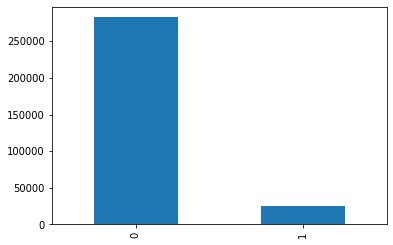

In [10]:
train['TARGET'].value_counts().plot(kind='bar')

As there are too many rows and also the target variable is imbalanced so for faster computation i choose to take random sample of the train dataset

In [11]:
train=train.sample(frac =.30) 

In [12]:
train['TARGET'].value_counts()

0    84844
1     7409
Name: TARGET, dtype: int64

In [13]:
numeric_columns=train.select_dtypes(include=['number']).columns

In [14]:
categorical_columns=set(train.columns)-set(numeric_columns)

In [15]:
len(numeric_columns)+len(categorical_columns)==len(train.columns)

True

In [16]:
#filling numerical values with mean
for i in numeric_columns:
  train[i].fillna(train[i].mean(),inplace=True)

In [17]:
#filling categorical values with mode
for i in categorical_columns:
  train[i].fillna(train[i].mode()[0],inplace=True)

In [18]:
#checking if there are any null values
train.columns[train.isnull().sum()>0]

Index([], dtype='object')

In [19]:
X=train.drop(['TARGET','SK_ID_CURR'],axis=1)
y=train['TARGET']

In [20]:
X.shape

(92253, 120)

In [21]:
X['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [22]:
dict_map={'Higher education':4, 'Secondary / secondary special':1,
       'Incomplete higher':3, 'Lower secondary':0, 'Academic degree':2}
X['NAME_EDUCATION_TYPE']=X['NAME_EDUCATION_TYPE'].map(dict_map)

In [23]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in categorical_columns:
  if i!='NAME_EDUCATION_TYPE':
    X[i]=le.fit_transform(X[i])

In [24]:
X['AMT_CREDIT']=np.log1p(X['AMT_CREDIT'])
X['AMT_INCOME_TOTAL']=np.log1p(X['AMT_INCOME_TOTAL'])
X['AMT_ANNUITY']=np.log1p(X['AMT_ANNUITY'])
X['AMT_GOODS_PRICE']=np.log1p(X['AMT_GOODS_PRICE'])

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [26]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
112473,1,0,0,1,0,11.707678,11.813037,8.817446,11.813037,6,7,1,1,1,0.020246,-18853,-3182,-10180.0,-2379,12.074253,1,1,0,1,0,0,8,2.0,3,3,1,11,0,0,0,0,0,0,11,0.502554,...,0.102985,0.109501,0.008679,0.02805,2,0,0.103072,4,0,1.0,0.0,1.0,0.0,-1691.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
163596,0,0,0,1,0,11.407576,11.588228,9.010791,11.407576,6,3,1,1,1,0.022625,-20120,365243,-5573.0,-3637,12.074253,1,0,0,1,0,0,8,2.0,2,2,2,14,0,0,0,0,0,0,57,0.502554,...,0.083800,0.124400,0.003900,0.06840,2,0,0.106100,5,0,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
144473,0,0,0,1,0,11.547337,13.259355,10.229783,13.112315,6,3,1,3,1,0.031329,-13536,365243,-13506.0,-4245,12.074253,1,0,0,1,0,0,8,1.0,2,2,1,12,0,0,0,0,0,0,57,0.502554,...,0.063300,0.059200,0.023300,0.01770,2,0,0.059400,0,0,4.0,0.0,4.0,0.0,-1280.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006754,0.006993,0.034148,0.267749,0.264623,1.906695
62765,0,0,0,1,0,11.967187,13.026955,10.325400,13.026955,6,7,1,0,1,0.008625,-18918,-4390,-8835.0,-2440,12.074253,1,1,1,1,1,0,8,2.0,2,2,6,9,0,0,0,0,0,0,11,0.664210,...,0.029100,0.012700,0.000000,0.00000,2,0,0.013100,4,0,0.0,0.0,0.0,0.0,-2332.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
252930,0,0,0,0,0,11.707678,12.504513,9.392870,12.323860,6,7,1,3,2,0.005002,-15951,-4028,-6207.0,-3988,12.074253,1,1,1,1,0,0,9,1.0,3,3,1,15,0,0,0,0,0,0,42,0.502554,...,0.102985,0.109501,0.008679,0.02805,2,0,0.103072,4,0,3.0,1.0,3.0,0.0,-711.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000


Logistic Regression Base Model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf=LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9226
           1       0.00      0.00      0.00         0

    accuracy                           0.92      9226
   macro avg       0.50      0.46      0.48      9226
weighted avg       1.00      0.92      0.96      9226



Logistic Regression with parameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = [    
    {'penalty' : ['l1', 'l2'],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [100,2500]
    }
]
gridclf = GridSearchCV(clf, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)
best_clf = gridclf.fit(X_train,y_train)
print(classification_report(best_clf.predict(X_test),y_test))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.9min finished


              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9210
           1       0.01      0.62      0.03        16

    accuracy                           0.92      9226
   macro avg       0.51      0.77      0.49      9226
weighted avg       1.00      0.92      0.96      9226



Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfclf=RandomForestClassifier().fit(X_train,y_train)
y_pred=rfclf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9222
           1       0.01      1.00      0.01         4

    accuracy                           0.92      9226
   macro avg       0.50      0.96      0.48      9226
weighted avg       1.00      0.92      0.96      9226



XGBoost Classifier

In [30]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier(objective='binary:logistic')
xgbclf.fit(X_train,y_train)
y_pred=xgbclf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9217
           1       0.01      0.67      0.02         9

    accuracy                           0.92      9226
   macro avg       0.50      0.79      0.49      9226
weighted avg       1.00      0.92      0.96      9226



LightGBM Classifier

In [31]:
from lightgbm import LGBMClassifier
m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                   eval_metric='Logloss')
m.fit(X_train, y_train,verbose=2)
y_pred=m.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      9154
           1       0.04      0.38      0.07        72

    accuracy                           0.92      9226
   macro avg       0.52      0.65      0.51      9226
weighted avg       0.99      0.92      0.95      9226

